# AAI 511 Final Project - Victor Hsu, Keith Holder - Composer Prediction Model

The code below shows our process for building a Composer prediction model

# Data collection

Unzip initial composers from kaggle website

In [13]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Extract Music Files
zip_path = '/content/drive/My Drive/AAI511_ML/midi_classic_music.zip'
extract_path = '/content/midi_classic_music/'

# Unzip the file.
!unzip -q -n "{zip_path}" -d "{extract_path}"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Keep only the composers mentioned in the final project

select the required composers from the given dataset.

1-Bach

2-Beethoven

3-Chopin

4-Mozart

In [14]:
import shutil

composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

for item in os.listdir(extract_path):
    item_path = os.path.join(extract_path, item)
    if os.path.isfile(item_path) and (item.endswith('.mid') or item.endswith('.MID')):
        os.remove(item_path)
        print(f"Remove file at root: {item}")

midi_classic_path = extract_path + 'midiclassics'

for item in os.listdir(midi_classic_path):
    item_path = os.path.join(midi_classic_path, item)
    if os.path.isfile(item_path) and (item.endswith('.mid') or item.endswith('.MID')):
        os.remove(item_path)
        print(f"Remove file at midi_classic_path: {item}")

# remove rest of non-composer files.
for root, dirs, files in os.walk(extract_path, topdown=False):
    for dir_name in dirs:
        if dir_name in composers:
            continue  # Keep this directory

        full_path = os.path.join(root, dir_name)
        contains_desired = False

        for subroot, subdirs, subfiles in os.walk(full_path):
            if any(composer in subdirs for composer in composers):
                contains_desired = True
                break

        if not contains_desired:
            shutil.rmtree(full_path)
            # print(f"Removed: {full_path}") for debugging

Remove file at root: Tchaikovsky Lake Of The Swans Act 2 13mov.mid
Remove file at root: Tchaikovsky Lake Of The Swans Act 2 11mov.mid
Remove file at root: Tchaikovsky Lake Of The Swans Act 2 14mov.mid
Remove file at root: Tchaikovsky Lake Of The Swans Act 2 10mov.mid
Remove file at root: Tchaicovsky Waltz of the Flowers.MID
Remove file at root: Tchaikovsky Lake Of The Swans Act 2 12mov.mid
Remove file at root: Tchaikovsky Lake Of The Swans Act 1 6mov.mid
Remove file at root: Rothchlid Symphony Rmw12 3mov.mid
Remove file at root: Tchaikovsky Lake Of The Swans Act 1 7-8movs.mid
Remove file at root: Rothchild Symphony Rmw12 2mov.mid
Remove file at root: Tchaikovsky Lake Of The Swans Act 1 5mov.mid
Remove file at root: Tchaikovsky Lake Of The Swans Act 1 9mov.mid
Remove file at root: Wagner Ride of the valkyries.mid
Remove file at root: Sibelius Kuolema Vals op44.mid
Remove file at root: Tchaikovsky Lake Of The Swans Act 1 3mov.mid
Remove file at root: Tchaikovsky Lake Of The Swans Act 1 1

# Pre-processing - feature extraction

Convert the musical scores into a format suitable for deep learning models. This involves converting the musical scores into MIDI files and applying data augmentation techniques. Feature extraction happens for notes, chords, etc. We parsed the MIDI files to extract musical notes/chords, and then built a vocabulary, converting into sequences that the model can process.

In [15]:
!pip install music21
!pip install mido

In [16]:
import numpy as np
import os
from collections import Counter
from pathlib import Path
import music21 # needed for pitch conversion
import mido    # faster MIDI parser
from multiprocessing import Pool, cpu_count

#  Get Song Paths
def get_songs_by_composer(root_dir):
    songs_dict = {}
    root_path = Path(root_dir)
    for composer_path in root_path.iterdir():
        if composer_path.is_dir():
            composer_name = composer_path.name.lower()
            songs_dict[composer_name] = list(composer_path.glob('**/*.mid*'))
    return songs_dict

# Feature extraction - notes from files
def parse_notes_from_file_mido(file_path):
    notes_to_parse = []
    try:
        midi_file = mido.MidiFile(file_path)
        current_chord_notes = []
        for msg in mido.merge_tracks(midi_file.tracks):
            if msg.time > 0 and current_chord_notes:
                current_chord_notes.sort()
                notes_to_parse.append('.'.join(current_chord_notes))
                current_chord_notes = []
            if msg.type == 'note_on' and msg.velocity > 0:
                pitch_name = music21.pitch.Pitch(midi=msg.note).nameWithOctave
                current_chord_notes.append(pitch_name)
        if current_chord_notes:
            current_chord_notes.sort()
            notes_to_parse.append('.'.join(current_chord_notes))
    except Exception as e:
        print(f"  - Could not parse {file_path} with mido: {e}")
    return notes_to_parse

if __name__ == '__main__':
    MIDI_ROOT_DIR = '/content/midi_classic_music/midiclassics/'

    print(f"Step 1: Building vocabulary in parallel using {cpu_count()} cores...")
    songs_dict = get_songs_by_composer(MIDI_ROOT_DIR)

    all_files = [file for files_list in songs_dict.values() for file in files_list]

    # Use a multiprocessing Pool to parse files in parallel
    with Pool() as pool:
        all_note_lists = pool.map(parse_notes_from_file_mido, all_files)

    # Flatten the list of lists into a single list of all notes
    all_notes = [note for sublist in all_note_lists for note in sublist]

    # feature extraction - vocabulary creation
    note_counts = Counter(all_notes)
    n_vocab = len(note_counts)
    pitch_names = sorted(note_counts.keys())
    note_to_int = {note: number for number, note in enumerate(pitch_names)}
    print(f"\nVocabulary Size (unique notes/chords): {n_vocab}")

    #  Create sequences and save
    print("\nStep 2: Creating sequences and labeling with composer IDs...")
    network_input = []
    network_output = []
    sequence_length = 100

    file_to_notes_map = dict(zip(all_files, all_note_lists))
    # feature extraction - Label Creation
    composer_map = {name: i for i, name in enumerate(sorted(songs_dict.keys()))}

    for composer_name, song_files in songs_dict.items():
        composer_id = composer_map[composer_name]
        for song_file in song_files:
            notes_in_song = file_to_notes_map[song_file] # Get notes from cache
            if len(notes_in_song) > sequence_length:
                for i in range(len(notes_in_song) - sequence_length):
                    # Feature extraction - This extracts fixed-length sequences (100 notes/chords) as input features, converting them to numerical representations.
                    sequence_in = notes_in_song[i : i + sequence_length]
                    network_input.append([note_to_int[note] for note in sequence_in])
                    network_output.append(composer_id)

    print("\nStep 3: Reshaping and normalizing data...")
    n_patterns = len(network_input)
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    network_input = network_input / float(n_vocab)
    network_output = np.array(network_output)

Step 1: Building vocabulary in parallel using 8 cores...
  - Could not parse /content/midi_classic_music/midiclassics/Beethoven/Anhang 14-3.mid with mido: Could not decode key with 3 flats and mode 255

Vocabulary Size (unique notes/chords): 55053

Step 2: Creating sequences and labeling with composer IDs...

Step 3: Reshaping and normalizing data...


# Saving pre-processed data

Saving to speed up execution later on.

In [6]:
# saved preprocessed data for later to save time.

drive.mount('/content/drive')
os.makedirs('/content/drive/MyDrive/AAI511_ML', exist_ok=True)

# we had to go through several iterations to get this right!
save_path = '/content/drive/MyDrive/AAI511_ML/preprocessed_composer_data_v4.npz'

print(f"\nSaving pre-processed data to {save_path}...")

np.savez_compressed(
    save_path,
    network_input=network_input,
    network_output=network_output,
    n_vocab=np.array([n_vocab]), # Save n_vocab as a numpy array
    composer_map=composer_map,   # Save the composer mapping dictionary
    note_to_int=note_to_int      # Save the note mapping dictionary
)

print("Data saved")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Saving pre-processed data to /content/drive/MyDrive/AAI511_ML/preprocessed_composer_data_v4.npz...
Data saved


## Model Training

data validation - make sure the data is what we expect from the preprocessing step
split - split into train/test/validation


In [7]:
!pip install --upgrade numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 105.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.2 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.

In [2]:
import numpy as np
print(f"NumPy version THIS session is using: {np.__version__}")
import os
from google.colab import drive
import zipfile

# Mount Google Drive
drive.mount('/content/drive')

save_path = '/content/drive/MyDrive/AAI511_ML/preprocessed_composer_data_v4.npz'

# print(f"Inspecting arrays inside: {save_path}\n") for debugging

try:
    with zipfile.ZipFile(save_path) as zf:
        for name in zf.namelist():
            if not name.endswith('.npy'):
                continue

            with zf.open(name) as fp:
                # get the file format version
                version = np.lib.format.read_magic(fp)

                # Call the correct header function based on the version
                if version[0] == 1:
                    shape, fortran_order, dtype = np.lib.format.read_array_header_1_0(fp)
                elif version[0] == 2:
                    shape, fortran_order, dtype = np.lib.format.read_array_header_2_0(fp)
                else:
                    print(f"--> Array: '{name.replace('.npy', '')}' has an unsupported format version: {version}")
                    continue

                array_name = name.replace('.npy', '')
                # more debugging
                # print(f"--> Array: '{array_name}'")
                # print(f"    Shape: {shape}")
                # print(f"    Data Type (dtype): {dtype}")
                # print("-" * 20)

except Exception as e:
    print(f"An error occurred while inspecting the file: {e}")

NumPy version THIS session is using: 2.3.2
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the preprocessed data
print(f"Loading preprocessed data from: {save_path}")
with np.load(save_path, allow_pickle=True) as data:
    network_input = data['network_input']
    network_output = data['network_output']
    composer_map = data['composer_map'].item()
    note_to_int = data['note_to_int'].item()
    sequence_length = network_input.shape[1]

    try:
        n_vocab = data['n_vocab'].item()
    except KeyError:
        # If not in npz, use note_to_int
        n_vocab = len(note_to_int)

print("Data loaded!")

# Split data into training (80%) and validation (20%) sets
print("Splitting data into training and validation sets...")
X_train, X_val, y_train, y_val = train_test_split(
    network_input,
    network_output,
    test_size=0.2,
    random_state=42, # for reproducibility
    stratify=network_output # Ensures same class distribution in train/val sets
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

Loading preprocessed data from: /content/drive/MyDrive/AAI511_ML/preprocessed_composer_data_v4.npz
Data loaded!
Splitting data into training and validation sets...
Training samples: 642152
Validation samples: 160539


In [4]:
def create_optimized_dataset(features, labels, batch_size=64, is_training=True):
    """Create an optimized dataset."""
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    if is_training:
        dataset = dataset.shuffle(len(features), reshuffle_each_iteration=True)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Create the datasets
BATCH_SIZE = 128
train_dataset = create_optimized_dataset(X_train, y_train, batch_size=BATCH_SIZE)
validation_dataset = create_optimized_dataset(X_val, y_val, batch_size=BATCH_SIZE, is_training=False)

print("\nTensorFlow datasets created.")


TensorFlow datasets created.


## Define/Compile LSTM-CNN Model

In [5]:
def build_cnn_lstm_model(input_shape, num_classes):
    """Builds a hybrid CNN-LSTM model for sequence classification."""
    model = tf.keras.Sequential([
        # Input Layer
        tf.keras.layers.Input(shape=input_shape),

        # 1. CNN Block: To find local musical patterns
        tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='causal'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Dropout(0.2),

        # 2. LSTM Block: To learn long-term structure
        tf.keras.layers.LSTM(256, return_sequences=False),
        tf.keras.layers.Dropout(0.3),

        # 3. Classification
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax') # Softmax for multi-class classification
    ])
    return model

# Get model parameters from the data
input_shape = X_train.shape[1:]
num_classes = len(np.unique(network_output))

# Build and compile the model
print("\nBuilding and compiling the model...")
model = build_cnn_lstm_model(input_shape=input_shape, num_classes=num_classes)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # adjusted learning rate after some attempts
    loss='sparse_categorical_crossentropy', # Use this for integer labels
    metrics=['accuracy']
)

model.summary()


Building and compiling the model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 100, 128)       │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,420 (1.63 MB)

 Trainable params: 428,420 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Add a callback to stop training early if performance plateaus
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Stop after 5 epochs with no improvement
    restore_best_weights=True # Restore the best model weights found
)

print("\nStarting model training...")
history = model.fit(
    train_dataset,
    epochs=40, # Set a high number, early stopping will find the best epoch
    validation_data=validation_dataset,
    callbacks=[early_stopping],
    verbose=0 # to keep code clean
)
print("\nModel training complete")


Starting model training...


In [8]:
import pickle

# save the model for later use, with meta data for easier testing.
model.save('/content/drive/MyDrive/AAI511_ML/composer_classifier_model_v2.keras')
print("Model saved as 'composer_classifier_model.keras'")

model_metadata = {
    'note_to_int': note_to_int,
    'composer_map': composer_map,
    'sequence_length': sequence_length,
    'n_vocab': n_vocab
}

metadata_path = os.path.join('/content/drive/MyDrive/AAI511_ML/', 'model_metadata_v2.pkl')
with open(metadata_path, 'wb') as f:
    pickle.dump(model_metadata, f)
print(f"Metadata saved to: {metadata_path}")

Model saved as 'composer_classifier_model.keras'
Metadata saved to: /content/drive/MyDrive/AAI511_ML/model_metadata_v2.pkl


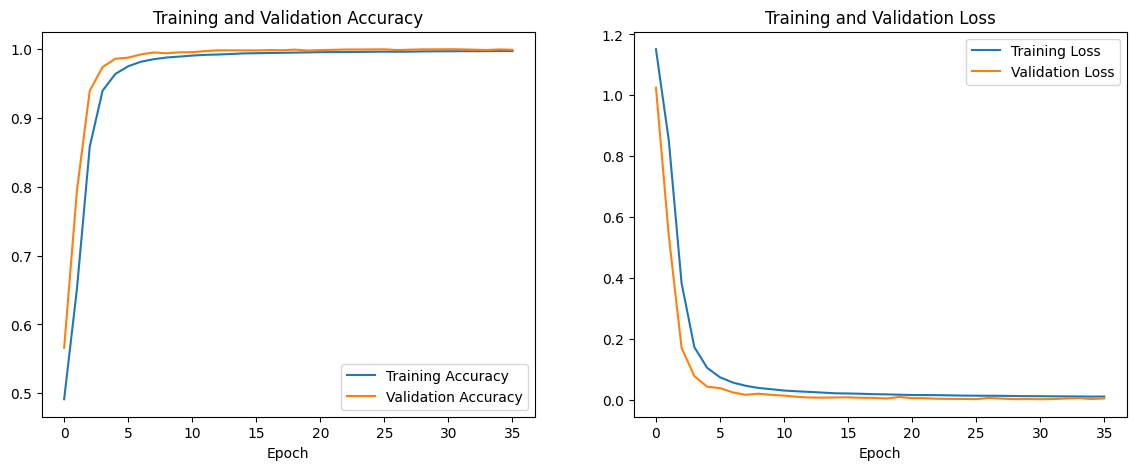

In [9]:
def plot_history(history):
    """Plots the training and validation accuracy and loss."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')

    plt.show()

plot_history(history)

In [17]:
# testing to make sure model works

def load_model_and_metadata(base_dir='/content/drive/MyDrive/AAI511_ML/'):
    """Load the saved model and metadata"""
    import os

    model_path = os.path.join(base_dir, 'composer_classifier_model_v2.keras')
    metadata_path = os.path.join(base_dir, 'model_metadata.pkl')

    # Load the model
    model_loaded = tf.keras.models.load_model(model_path)
    print(f"Model loaded from: {model_path}")

    # Load metadata
    with open(metadata_path, 'rb') as f:
        metadata = pickle.load(f)
    print(f"Metadata loaded from: {metadata_path}")

    return model_loaded, metadata

# simple test function
def test_midi_file(file_path, base_dir='/content/drive/MyDrive/AAI511_ML/'):
    """Test a single MIDI file using saved model"""
    import numpy as np

    # Load model and metadata
    model, metadata = load_model_and_metadata(base_dir)

    # Parse the MIDI file
    notes = parse_notes_from_file_mido(file_path)

    if len(notes) < metadata['sequence_length']:
        print(f"File too short: {len(notes)} notes, need {metadata['sequence_length']}")
        return

    # Take first sequence
    test_sequence = notes[:metadata['sequence_length']]

    # Convert to integers
    try:
        int_sequence = [metadata['note_to_int'][note] for note in test_sequence]
    except KeyError as e:
        print(f"Unknown note in file: {e}")
        return

    # Preprocess
    test_input = np.array(int_sequence).reshape(1, metadata['sequence_length'], 1)
    test_input = test_input / float(metadata['n_vocab'])

    # Predict
    prediction = model.predict(test_input, verbose=0)
    predicted_id = np.argmax(prediction[0])
    confidence = prediction[0][predicted_id]

    # Get composer name
    id_to_composer = {v: k for k, v in metadata['composer_map'].items()}
    predicted_composer = id_to_composer[predicted_id]

    print(f"\nTesting: {os.path.basename(file_path)}")
    print(f"Predicted composer: {predicted_composer.upper()}")
    print(f"Confidence: {confidence:.4f}")

    # Show top 3 predictions
    top_3 = np.argsort(prediction[0])[-3:][::-1]
    print(f"\n🏆 Top 3 predictions:")
    for i, idx in enumerate(top_3):
        composer = id_to_composer[idx]
        prob = prediction[0][idx]
        print(f"   {i+1}. {composer}: {prob:.4f}")

test_file = '/content/midi_classic_music/midiclassics/Bach/AveMaria.mid'
# add more test files here for more testing as needed
test_midi_file(test_file)

# the warning is expected and has no impact on model performance

Model loaded from: /content/drive/MyDrive/AAI511_ML/composer_classifier_model_v2.keras
Metadata loaded from: /content/drive/MyDrive/AAI511_ML/model_metadata.pkl

Testing: AveMaria.mid
Predicted composer: BACH
Confidence: 1.0000

🏆 Top 3 predictions:
   1. bach: 1.0000
   2. beethoven: 0.0000
   3. mozart: 0.0000


In [18]:
from sklearn.metrics import classification_report
import numpy as np

print("Generating classification report for the validation set...")

# Get the model's predictions on the validation data
# The model outputs probabilities, so we use np.argmax to get the predicted class index
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get the true labels
y_true = y_val

# Get the composer names from the map for a more readable report
# Sort by the class index (0, 1, 2, ...) to match the report order
target_names = sorted(composer_map, key=composer_map.get)

# Generate and print the report
print("\n Classification Report ")
print(classification_report(y_true, y_pred, target_names=target_names))

Generating classification report for the validation set...
5017/5017 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step

 Classification Report 
              precision    recall  f1-score   support

        bach       1.00      1.00      1.00     35714
   beethoven       1.00      1.00      1.00     60499
      chopin       1.00      1.00      1.00     37711
      mozart       1.00      1.00      1.00     26615

    accuracy                           1.00    160539
   macro avg       1.00      1.00      1.00    160539
weighted avg       1.00      1.00      1.00    160539

